In this notebook we want to assess the difference in noise correlations between models trained with and without dropout.

We do that by:

1. Training the networks with and without dropouts
2. Collecting the embedding layers activations on test data
3. Training classifiers on the embedding layers suffled activity, and assessing it unshuffled test data (for both dropout and non-dropout networks)
4. Assessing covariance of embedding layer 

5. Finally we vary the dropout probability and determine noise correlations as a function of dropout probability (or batch size, not sure)

In [1]:
import tensorflow as tf

In [2]:
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets('MNIST_data', one_hot=True)

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


We make the most vanilla convnet to run MNIST. This is literally the exact conv-net from the 'deep mnist for experts' tutorial. 

We can specify at training time the keep probability, which when we want to set a network with no dropout we just set to 0. 

In [3]:
def weight_variable(shape):
  initial = tf.truncated_normal(shape, stddev=0.1)
  return tf.Variable(initial)

def bias_variable(shape):
  initial = tf.constant(0.1, shape=shape)
  return tf.Variable(initial)

def conv2d(x, W):
  return tf.nn.conv2d(x, W, strides=[1, 1, 1, 1], padding='SAME')

def max_pool_2x2(x):
  return tf.nn.max_pool(x, ksize=[1, 2, 2, 1],
                        strides=[1, 2, 2, 1], padding='SAME')

In [78]:
class convNet():
    def __init__(self, n_hidden_layer = 4096):
        
        tf.reset_default_graph()
        self.sess = tf.Session()
        self.x = tf.placeholder(tf.float32, shape=[None, 784])
        self.y_ = tf.placeholder(tf.float32, shape=[None, 10])

        self.W_conv1 = weight_variable([5, 5, 1, 32])
        self.b_conv1 = bias_variable([32])

        self.x_image = tf.reshape(self.x, [-1,28,28,1])

        self.h_conv1 = tf.nn.relu(conv2d(self.x_image, self.W_conv1) + self.b_conv1)
        self.h_pool1 = max_pool_2x2(self.h_conv1)

        self.W_conv2 = weight_variable([5, 5, 32, 64])
        self.b_conv2 = bias_variable([64])

        self.h_conv2 = tf.nn.relu(conv2d(self.h_pool1, self.W_conv2) + self.b_conv2)
        self.h_pool2 = max_pool_2x2(self.h_conv2)

        self.W_fc1 = weight_variable([7 * 7 * 64, n_hidden_layer])
        self.b_fc1 = bias_variable([n_hidden_layer])

        self.h_pool2_flat = tf.reshape(self.h_pool2, [-1, 7*7*64])
        self.h_fc1 = tf.nn.relu(tf.matmul(self.h_pool2_flat, self.W_fc1) + self.b_fc1)

        self.keep_prob = tf.placeholder(tf.float32)
        self.h_fc1_drop = tf.nn.dropout(self.h_fc1, self.keep_prob)

        self.W_fc2 = weight_variable([n_hidden_layer, 10])
        self.b_fc2 = bias_variable([10])

        self.y_conv = tf.matmul(self.h_fc1_drop, self.W_fc2) + self.b_fc2
        
        self.cross_entropy = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(self.y_conv, self.y_))
        self.train_step = tf.train.AdamOptimizer(1e-4).minimize(self.cross_entropy)
        self.correct_prediction = tf.equal(tf.argmax(self.y_conv,1), tf.argmax(self.y_,1))
        self.accuracy = tf.reduce_mean(tf.cast(self.correct_prediction, tf.float32))
        self.sess.run(tf.initialize_all_variables())
        
    def fit(self, max_iters = 2000, epoch_size = 100, batch_size = 50, train_keep_prob = .5):
        for i in range(max_iters):
            batch = mnist.train.next_batch(batch_size)
            if i%epoch_size == 0:
                train_accuracy = self.accuracy.eval(session = self.sess, feed_dict={
                    self.x:batch[0], self.y_: batch[1], self.keep_prob: 1.0})
                print("step %d, training accuracy %g"%(i, train_accuracy))
            
            self.sess.run(self.train_step, feed_dict={
                self.x: batch[0], self.y_: batch[1], self.keep_prob: train_keep_prob})

        print("test accuracy %g"%self.accuracy.eval(session = self.sess, feed_dict={
            self.x: mnist.test.images, self.y_: mnist.test.labels, self.keep_prob: 1.0}))
        

In [79]:
drop_net = convNet()
drop_net.fit(max_iters = 5000, batch_size = 100)

step 0, training accuracy 0.02
step 100, training accuracy 0.93
step 200, training accuracy 0.95
step 300, training accuracy 0.93
step 400, training accuracy 0.94
step 500, training accuracy 0.97
step 600, training accuracy 0.93
step 700, training accuracy 0.99
step 800, training accuracy 1
step 900, training accuracy 0.97
step 1000, training accuracy 0.98
step 1100, training accuracy 0.99
step 1200, training accuracy 1
step 1300, training accuracy 0.99
step 1400, training accuracy 0.98
step 1500, training accuracy 0.98
step 1600, training accuracy 0.99
step 1700, training accuracy 1
step 1800, training accuracy 1
step 1900, training accuracy 0.98
step 2000, training accuracy 1
step 2100, training accuracy 0.99
step 2200, training accuracy 0.99
step 2300, training accuracy 0.99
step 2400, training accuracy 0.99
step 2500, training accuracy 1
step 2600, training accuracy 0.99
step 2700, training accuracy 0.99
step 2800, training accuracy 0.99
step 2900, training accuracy 1
step 3000, tr

In [80]:
#trials = [sess.run(h_fc1_drop, feed_dict = {x: mnist.test.images[0:100], keep_prob: .5}) for i in range(50)]
#on a small amazon instance can't do more than 10000 training examples. Will fix this tmrw once the code is written. 

all_units = drop_net.sess.run(drop_net.h_fc1_drop, feed_dict = {drop_net.x: mnist.test.images, drop_net.keep_prob: 1})

In [81]:
import numpy as np

ylabels = [np.argmax(row) for row in mnist.test.labels] 

In [82]:
from sklearn.linear_model import LogisticRegression
from sklearn.cross_validation import train_test_split
from sklearn.preprocessing import LabelEncoder

#ylabels = LabelEncoder().fit_transform(mnist.test.labels[0:1000])

X_train, X_test, y_train, y_test = train_test_split(all_units, ylabels)

model = LogisticRegression()
model.fit(X_train, y_train)
model.score(X_test, y_test)

0.98999999999999999

In [83]:
def tensorize(data, labels, est_trials = 100, shuffle = False):
    n_points, n_neurons = data.shape
    n_classes = len(set(labels))
    
    tensor = np.empty([n_classes, est_trials, n_neurons])
    trial_count = np.zeros(n_classes).astype('int')
    
    for i in range(n_points):
        
        tensor[labels[i]][trial_count[labels[i]]] = data[i]
        trial_count[labels[i]] += 1
        
    num_trials = min(trial_count).astype('int')
    tensor = tensor[:, 0:num_trials,: ]
    
    if shuffle:
        
        for i in range(n_neurons):
            for j in range(n_classes):      
                tensor[j, :, i] = np.random.permutation(tensor[j, :, i])

    labels = [range(10) for i in range(num_trials)]
    labels = np.array(labels).transpose()
    
    return tensor, labels

In [85]:
no_shuf_test = []

for i in range(100):
    train_tensor, train_labels = tensorize(X_train, y_train, est_trials = 1000, shuffle = True)
    test_tensor, test_labels = tensorize(X_test, y_test, est_trials = 1000, shuffle = False)

    train_tensor, train_labels = train_tensor.reshape(-1, 4096), train_labels.reshape([-1])
    test_tensor, test_labels = test_tensor.reshape(-1, 4096), test_labels.reshape([-1])
    
    model = LogisticRegression()
    model.fit(train_tensor, train_labels)
    no_shuf_test.append(model.score(X_test, y_test))

In [87]:
shuf_test = []

for i in range(100):
    train_tensor, train_labels = tensorize(X_train, y_train, est_trials = 1000, shuffle = True)
    test_tensor, test_labels = tensorize(X_test, y_test, est_trials = 1000, shuffle = True)

    train_tensor, train_labels = train_tensor.reshape(-1, 4096), train_labels.reshape([-1])
    test_tensor, test_labels = test_tensor.reshape(-1, 4096), test_labels.reshape([-1])

    model = LogisticRegression()
    model.fit(train_tensor, train_labels)
    shuf_test.append(model.score(X_test, y_test))

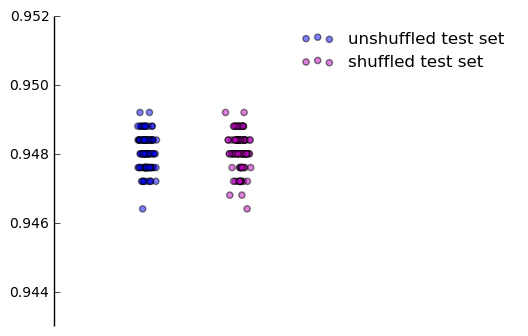

In [88]:
import matplotlib.pyplot as plt
%matplotlib inline

ax = plt.subplot(111)
plt.scatter(np.random.normal(.1, .005, size=[100]), no_shuf_test, c = 'b', alpha = .5, label = 'unshuffled test set')
plt.scatter(np.random.normal(.2, .005, size = [100]), shuf_test, c = 'm', alpha = .5, label = 'shuffled test set')
plt.xlim([0, .5])
simpleaxis(ax, bottom = True)
plt.legend(frameon = False)


In [61]:
def simpleaxis(ax, bottom = False):
    '''
    remove the top and right spines and ticks from the axis. 
    '''
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    if bottom:
        ax.spines['bottom'].set_visible(False)
        ax.get_xaxis().set_ticks([])
    else:
        ax.get_xaxis().tick_bottom()


    ax.get_yaxis().tick_left()